In [38]:
import os

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import matplotlib.cm as cm
import numpy as np
import math

# Introduction

# User input

In [2]:
nc_fpath = r'/home/jovyan/shared/common/oslofjord_modelling/MARTINI800v10_river_inputs/martini_river_1990_2022_pwa2.nc'
setup_fpath = r'/home/jovyan/shared/common/oslofjord_modelling/oslofjord_location_ids.csv'
river_names_fpath = r'/home/jovyan/shared/common/oslofjord_modelling/MARTINI800v10_river_inputs/river_names.csv'
wwtp_fpath = r'/home/jovyan/shared/common/oslofjord_modelling/MARTINI800v10_river_inputs/martini800_v10a_isource_1990_2022.nc'

start_year = 2016
end_year = 2022

# Folder to save output in
fig_folder = r'../plots'
flux_folder = r'../data/fluxes/kernel_smoothing'

# Variables of interest from the ERSEM river input netcdf file
riv_var_li = ["river_transport", "river_TOTN", "river_N3_n", "river_N4_n"]

# Model river numbers of interest
oslofjord_riv_nos = range(5, 26)  # Model river numbers

# Direct point source inputs to include in the domain
# (see Phil's map for location of ids)
isource_oslofjord_ids = list(range(1, 14)) + [23]

# Molecular weight of N (g/mole)
Mr_N = 14.0067

# Read in metadata

In [4]:
# Mapping from model river number to real river number
river_nos_s = pd.read_csv(setup_fpath, index_col=0).squeeze('columns')
river_nos_s.head()

model_river
1    1
2    1
3    2
4    3
5    4
Name: real_river, dtype: int64

In [5]:
# Mapping from real river number to river name
river_names_s = pd.read_csv(river_names_fpath, index_col=0).squeeze('columns')
river_names_s.head()

real_river
1         Göta älv
2           Bäveån
3     Örekilsälven
4         Strömsån
5    Enningdalsälv
Name: river_name, dtype: object

In [6]:
# river_df = meta_df[['river', 'model_river_min', 'model_river_max']].drop_duplicates()

# Read in direct WWTP fjord inputs

In [29]:
# WWTP direct inputs
wwtp_ds = xr.open_dataset(wwtp_fpath)

# Sum over the 's_rho' dimension
wwtp_ds = wwtp_ds.sum(dim='s_rho')

wwtp_ds

<xarray.Dataset>
Dimensions:            (isource: 23, isource_time: 398)
Coordinates:
  * isource            (isource) float64 1.0 2.0 3.0 4.0 ... 20.0 21.0 22.0 23.0
  * isource_time       (isource_time) datetime64[ns] 1989-12-15 ... 2023-01-15
Data variables: (12/36)
    isource_CR1_c      (isource_time, isource) float64 24.24 308.6 ... 5.176 0.0
    isource_CR1_n      (isource_time, isource) float64 0.08171 0.6749 ... 0.0
    isource_CR1_p      (isource_time, isource) float64 7.568e-05 ... 0.0
    isource_CR2_c      (isource_time, isource) float64 9.618 67.43 ... 0.0 0.0
    isource_CR2_n      (isource_time, isource) float64 0.07992 0.6602 ... 0.0
    isource_CR2_p      (isource_time, isource) float64 1.892e-05 ... 0.0
    ...                 ...
    isource_R6_n       (isource_time, isource) float64 0.6825 5.638 ... 0.0
    isource_R6_p       (isource_time, isource) float64 0.003686 0.03401 ... 0.0
    isource_R8_c       (isource_time, isource) float64 45.29 462.0 ... 5.392 0.0
    isource_R8_n       (isource_time, isource) float64 0.6825 5.638 ... 0.0
    isource_R8_p       (isource_time, isource) float64 0.003686 0.03401 ... 0.0
    isource_Xposition  (isource) float64 402.0 408.0 420.0 ... 331.0 328.0 470.0

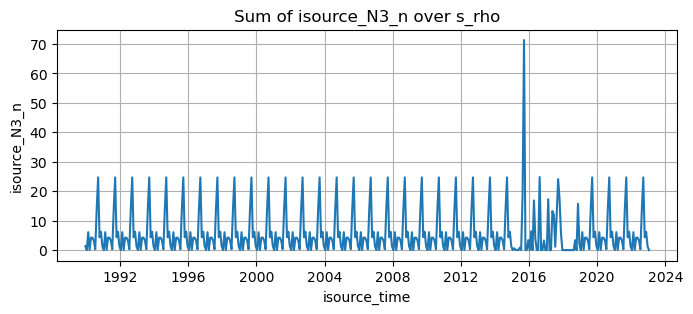

In [31]:
# Quick plot for a single WWTP
selected_data = wwtp_ds.sel(isource=23)
plt.figure(figsize=(8, 3))
plt.plot(selected_data['isource_time'], selected_data['isource_N3_n'])
plt.xlabel('isource_time')
plt.ylabel('isource_N3_n')
plt.title('Sum of isource_N3_n over s_rho')
plt.grid(True)
plt.show()

In [41]:
wwtp_df = wwtp_ds.to_dataframe()
wwtp_df = wwtp_df.reset_index()  # Drop multiindex
wwtp_ds.close()
wwtp_df

,isource,isource_time,isource_CR1_c,isource_CR1_n,isource_CR1_p,isource_CR2_c,isource_CR2_n,isource_CR2_p,isource_CR3_c,isource_CR3_n,...,isource_R4_c,isource_R4_n,isource_R4_p,isource_R6_c,isource_R6_n,isource_R6_p,isource_R8_c,isource_R8_n,isource_R8_p,isource_Xposition
0,1.0,1989-12-15,24.241725,0.081707,0.000076,9.617707,0.079922,0.000019,9.617707,0.079922,...,45.288686,0.682544,0.003686,45.288686,0.682544,0.003686,45.288686,0.682544,0.003686,402.0
1,1.0,1990-01-15,24.241725,0.081707,0.000076,9.617707,0.079922,0.000019,9.617707,0.079922,...,45.288686,0.682544,0.003686,45.288686,0.682544,0.003686,45.288686,0.682544,0.003686,402.0
2,1.0,1990-02-15,24.241725,0.081707,0.000076,9.617707,0.079922,0.000019,9.617707,0.079922,...,45.288686,0.682544,0.003686,45.288686,0.682544,0.003686,45.288686,0.682544,0.003686,402.0
3,1.0,1990-03-15,24.241725,0.081707,0.000076,9.617707,0.079922,0.000019,9.617707,0.079922,...,45.288686,0.682544,0.003686,45.288686,0.682544,0.003686,45.288686,0.682544,0.003686,402.0
4,1.0,1990-04-15,24.241725,0.081707,0.000076,9.617707,0.079922,0.000019,9.617707,0.079922,...,45.288686,0.682544,0.003686,45.288686,0.682544,0.003686,45.288686,0.682544,0.003686,402.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9149,23.0,2022-09-15,303.279693,0.820350,0.044475,68.252190,0.205087,0.011119,22.750730,0.205087,...,410.711056,7.726588,0.401513,410.711056,7.726588,0.401513,410.711056,7.726588,0.401513,470.0
9150,23.0,2022-10-15,1.752000,0.000000,0.000635,13.843626,0.000000,0.000159,4.614542,0.000000,...,21.052258,0.000000,0.005732,21.052258,0.000000,0.005732,21.052258,0.000000,0.005732,470.0
9151,23.0,2022-11-15,139.399521,0.316007,0.016292,19.364095,0.079002,0.004073,6.454698,0.079002,...,172.102411,4.067321,0.147077,172.102411,4.067321,0.147077,172.102411,4.067321,0.147077,470.0
9152,23.0,2022-12-15,24.080013,0.065252,0.003429,6.260197,0.016313,0.000857,2.086732,0.016313,...,33.778065,0.825934,0.030953,33.778065,0.825934,0.030953,33.778065,0.825934,0.030953,470.0


In [42]:
# Drop all columns which are not N fluxes
cols_to_keep = ['isource', 'isource_time'] + [col for col in wwtp_df.columns if col.endswith('_n')]
wwtp_df = wwtp_df[cols_to_keep]

# Drop all WWTPs which are outside oslofjord
wwtp_df = wwtp_df[wwtp_df['isource'].isin(isource_oslofjord_ids)]

wwtp_df['isource_time'] = pd.to_datetime(wwtp_df['isource_time'])

print('Number of WWTPs: %s ' % len(wwtp_df['isource'].drop_duplicates()))
wwtp_df

Number of WWTPs: 14 


,isource,isource_time,isource_CR1_n,isource_CR2_n,isource_CR3_n,isource_N3_n,isource_N4_n,isource_NR1_n,isource_NR2_n,isource_NR3_n,isource_R4_n,isource_R6_n,isource_R8_n
0,1.0,1989-12-15,0.081707,0.079922,0.079922,1.561753,43.446470,0.939630,0.919104,0.919104,0.682544,0.682544,0.682544
1,1.0,1990-01-15,0.081707,0.079922,0.079922,1.561753,43.446470,0.939630,0.919104,0.919104,0.682544,0.682544,0.682544
2,1.0,1990-02-15,0.081707,0.079922,0.079922,1.561753,43.446470,0.939630,0.919104,0.919104,0.682544,0.682544,0.682544
3,1.0,1990-03-15,0.081707,0.079922,0.079922,1.561753,43.446470,0.939630,0.919104,0.919104,0.682544,0.682544,0.682544
4,1.0,1990-04-15,0.081707,0.079922,0.079922,1.561753,43.446470,0.939630,0.919104,0.919104,0.682544,0.682544,0.682544
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9149,23.0,2022-09-15,0.820350,0.205087,0.205087,24.673960,107.670878,9.434020,2.358505,2.358505,7.726588,7.726588,7.726588
9150,23.0,2022-10-15,0.000000,0.000000,0.000000,4.362774,4.972806,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9151,23.0,2022-11-15,0.316007,0.079002,0.079002,6.231788,41.475941,3.634082,0.908521,0.908521,4.067321,4.067321,4.067321
9152,23.0,2022-12-15,0.065252,0.016313,0.016313,1.328581,8.564359,0.750401,0.187600,0.187600,0.825934,0.825934,0.825934


In [43]:
# Calculate TOTN
cols_to_exclude = ['isource', 'isource_time']
cols_to_sum = [col for col in cols_to_keep if col not in cols_to_exclude]

# Create a new column 'sum' that is the sum of all columns in cols_to_sum
wwtp_df['TOTN'] = wwtp_df[cols_to_sum].sum(axis=1)
wwtp_df['DIN'] = wwtp_df['isource_N3_n'] + wwtp_df['isource_N4_n']

# Drop all the subfractions apart from TOTN and DIN
wwtp_df = wwtp_df.drop(cols_to_sum, axis=1)

wwtp_df

,isource,isource_time,TOTN,DIN
0,1.0,1989-12-15,50.075242,45.008222
1,1.0,1990-01-15,50.075242,45.008222
2,1.0,1990-02-15,50.075242,45.008222
3,1.0,1990-03-15,50.075242,45.008222
4,1.0,1990-04-15,50.075242,45.008222
...,...,...,...,...
9149,23.0,2022-09-15,170.906156,132.344839
9150,23.0,2022-10-15,9.335579,9.335579
9151,23.0,2022-11-15,65.834827,47.707729
9152,23.0,2022-12-15,13.594220,9.892939


In [47]:
# Convert units from mmol/s to 10^6 kg/month (same as monthly river fluxes)
# NB NEEDS IMPROVING, not accurate now, uses average number of days/month
# instead of actual number of days/month
for var in ['TOTN', 'DIN']:
    wwtp_df[var] = wwtp_df[var] * Mr_N * 86400 * 30.417 * 10**-12
wwtp_df

,isource,isource_time,TOTN,DIN
0,1.0,1989-12-15,0.001843,0.001657
1,1.0,1990-01-15,0.001843,0.001657
2,1.0,1990-02-15,0.001843,0.001657
3,1.0,1990-03-15,0.001843,0.001657
4,1.0,1990-04-15,0.001843,0.001657
...,...,...,...,...
9149,23.0,2022-09-15,0.006291,0.004872
9150,23.0,2022-10-15,0.000344,0.000344
9151,23.0,2022-11-15,0.002423,0.001756
9152,23.0,2022-12-15,0.000500,0.000364


## Quick plot

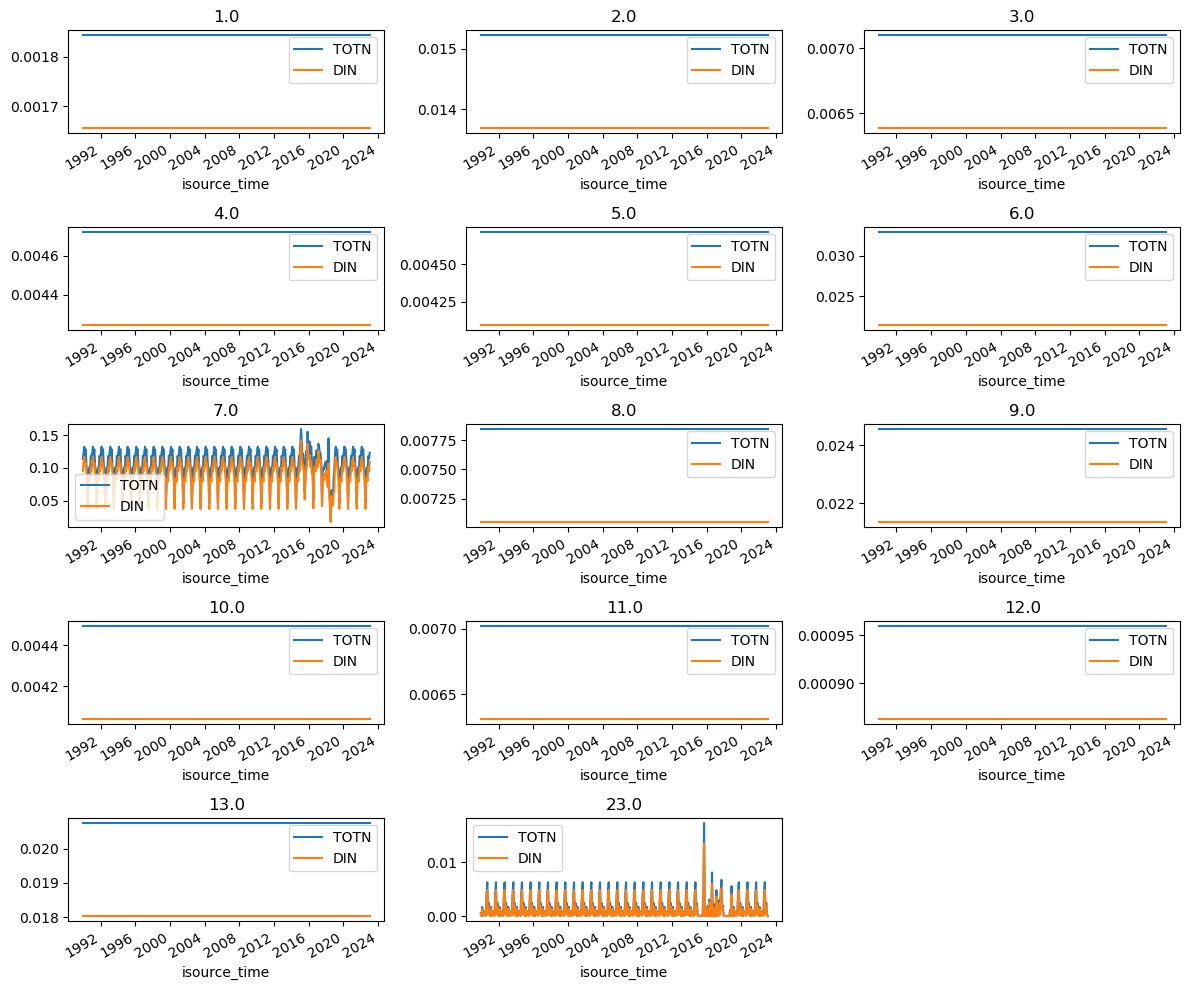

In [48]:
wwtp_list = wwtp_df['isource'].unique()

n = len(wwtp_list)
ncols = 3
nrows = math.ceil(n / ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 2*nrows))
axs = axs.flatten()

for i, wwtp in enumerate(wwtp_list):
    temp_df = wwtp_df[wwtp_df['isource'] == wwtp]
    temp_df.set_index('isource_time', inplace=True)
    temp_df[['TOTN', 'DIN']].plot(ax=axs[i])
    axs[i].set_title(f'{wwtp}')

# Remove unused subplots
if n % ncols != 0:
    for j in range(n, nrows*ncols):
        fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

This is as expected. From Phil: Sources (7,23) are VEAS (main outlet, overflow outlet).  That is the only RA for which we have temporally variable data (originally daily resolution, averaged over months) but we currently only have such data for 2015-2018, so for the other years I filled with climatology.  For all the other RAs we have only annual estimates for the year 2018., and I have filled the other years assuming a constant loads.

# ERSEM river data processing

## Read in and tidy

In [49]:
ds = xr.open_dataset(nc_fpath)
ds = ds[riv_var_li]
ds

<xarray.Dataset>
Dimensions:          (river_time: 12053, river: 46, s_rho: 42)
Coordinates:
  * river            (river) float64 1.0 2.0 3.0 4.0 5.0 ... 43.0 44.0 45.0 46.0
  * river_time       (river_time) datetime64[ns] 1990-01-01T12:00:00 ... 2022...
Dimensions without coordinates: s_rho
Data variables:
    river_transport  (river_time, river) float64 ...
    river_TOTN       (river_time, s_rho, river) float64 ...
    river_N3_n       (river_time, s_rho, river) float64 ...
    river_N4_n       (river_time, s_rho, river) float64 ...
Attributes:
    history:  Mon Dec  4 15:59:00 2023: ncks -4 -L 5 martini_river_1990_2022_...
    NCO:      4.7.2

In [50]:
df = ds.to_dataframe()
df = df.reset_index()  # Drop multiindex
ds.close()
df.head()

,river_time,river,s_rho,river_transport,river_TOTN,river_N3_n,river_N4_n
0,1990-01-01 12:00:00,1.0,0,-180.2,48.923564,34.462138,1.704232
1,1990-01-01 12:00:00,1.0,1,-180.2,48.923564,34.462138,1.704232
2,1990-01-01 12:00:00,1.0,2,-180.2,48.923564,34.462138,1.704232
3,1990-01-01 12:00:00,1.0,3,-180.2,48.923564,34.462138,1.704232
4,1990-01-01 12:00:00,1.0,4,-180.2,48.923564,34.462138,1.704232


In [51]:
if 's_rho' in df.columns:
    df = df.drop(columns=['s_rho'])
    df = df.drop_duplicates()  # There were around 40 s_rho values for each (river_time, river)

df = df.sort_values(by=['river', 'river_time'])

# Drop negative discharge values (assume they give direction)
df['river_transport'] = df['river_transport'].abs()

df = df.reset_index(drop=True)

# Add real river name and number
df['river_no'] = df['river'].map(river_nos_s)
df['river_name'] = df['river_no'].map(river_names_s)

df.head()

,river_time,river,river_transport,river_TOTN,river_N3_n,river_N4_n,river_no,river_name
0,1990-01-01 12:00:00,1.0,180.20,48.923564,34.462138,1.704232,1,Göta älv
1,1990-01-02 12:00:00,1.0,380.80,48.991515,34.463822,1.701404,1,Göta älv
2,1990-01-03 12:00:00,1.0,489.60,49.058751,34.465485,1.698612,1,Göta älv
3,1990-01-04 12:00:00,1.0,353.60,49.125046,34.467123,1.695870,1,Göta älv
4,1990-01-05 12:00:00,1.0,408.85,49.190185,34.468731,1.693187,1,Göta älv


## Select just Oslofjord rivers

In [52]:
# New dataframe with just the Oslofjord rivers
df = df[df['river'].isin(oslofjord_riv_nos)]

# Drop all river identifiers apart from the name
df = df.drop(columns=['river', 'river_no'])

print(len(df['river_name'].drop_duplicates()))
df.head()

16


,river_time,river_transport,river_TOTN,river_N3_n,river_N4_n,river_name
48212,1990-01-01 12:00:00,0.745,63.661045,26.280826,3.075184,Strömsån
48213,1990-01-02 12:00:00,0.641,63.602295,26.390396,3.091376,Strömsån
48214,1990-01-03 12:00:00,0.653,63.544136,26.499309,3.107461,Strömsån
48215,1990-01-04 12:00:00,0.581,63.486761,26.607132,3.123372,Strömsån
48216,1990-01-05 12:00:00,0.543,63.430354,26.713452,3.139044,Strömsån


## If desired, truncate to time period of interest

In [53]:
df['year'] = df['river_time'].dt.year
df = df.loc[(df['year'] >= start_year) & (df['year'] <= end_year)]
df = df.drop('year', axis=1)
df

,river_time,river_transport,river_TOTN,river_N3_n,river_N4_n,river_name
57708,2016-01-01 12:00:00,0.87000,62.194333,25.716716,2.816261,Strömsån
57709,2016-01-02 12:00:00,0.91400,62.789506,26.511660,2.850371,Strömsån
57710,2016-01-03 12:00:00,0.80500,63.321413,27.219199,2.880678,Strömsån
57711,2016-01-04 12:00:00,0.62200,63.774004,27.817895,2.906263,Strömsån
57712,2016-01-05 12:00:00,0.52500,64.143227,28.303109,2.926940,Strömsån
...,...,...,...,...,...,...
301320,2022-12-27 12:00:00,11.71659,149.355552,113.566897,19.999519,Aulielva
301321,2022-12-28 12:00:00,11.71659,150.296840,114.503175,19.897703,Aulielva
301322,2022-12-29 12:00:00,11.71659,151.225826,115.428729,19.796779,Aulielva
301323,2022-12-30 12:00:00,11.71659,152.136105,116.337032,19.697491,Aulielva


## Real river data (sum over model rivers)

In [54]:
# Check if all values in each group are the same (they should be, except for model_river)
for column in df.columns:
    if column not in ['river_name', 'river_time', 'river_transport']:
        is_constant = df.groupby(['river_name', 'river_time'])[column].nunique() <= 1
        if not is_constant.all():
            print(f"Values in column '{column}' are not the same for all 'river_name'")
        else:
            print("Values constant")

Values constant
Values constant
Values constant


In [55]:
# Sum up discharge
conc_df = df.groupby(['river_name', 'river_time']).agg({'river_transport': 'sum'})

# Mean of all other columns within each river
mean_df = df.groupby(['river_name', 'river_time'])[riv_var_li[1:]].mean()

# Add the mean columns to 'grouped_df'
conc_df = pd.concat([conc_df, mean_df], axis=1)

conc_df = conc_df.reset_index()

# Convert concentration units from mMoles/m3 to mg/l
# HARDCODED, needs generalising for diff vars & units
for col in riv_var_li[1:]:
    conc_df[col] = conc_df[col] * Mr_N * 0.001

# Rename cols
# Warning: HARDCODED, needs generalising for diff vars
new_col_names = ['river', 'date', 'Q', 'TOTN', 'NOx-N', 'NH4-N']
conc_df = conc_df.set_axis(new_col_names, axis=1)
conc_df['DIN'] = conc_df['NOx-N'] + conc_df['NH4-N']

conc_df

,river,date,Q,TOTN,NOx-N,NH4-N,DIN
0,Akerselva,2016-01-01 12:00:00,4.138779,0.426616,0.219778,0.016531,0.236309
1,Akerselva,2016-01-02 12:00:00,4.034369,0.428505,0.220920,0.015523,0.236443
2,Akerselva,2016-01-03 12:00:00,3.455147,0.429193,0.221342,0.015157,0.236499
3,Akerselva,2016-01-04 12:00:00,3.229457,0.428917,0.221134,0.015041,0.236176
4,Akerselva,2016-01-05 12:00:00,3.092570,0.426859,0.219705,0.014830,0.234534
...,...,...,...,...,...,...,...
40907,Årungen,2022-12-27 12:00:00,6.813638,2.308466,2.278415,0.011632,2.290047
40908,Årungen,2022-12-28 12:00:00,7.634030,2.314097,2.284338,0.011328,2.295666
40909,Årungen,2022-12-29 12:00:00,7.296922,2.320198,2.290696,0.011057,2.301752
40910,Årungen,2022-12-30 12:00:00,7.677933,2.326793,2.297514,0.010814,2.308328


# Plot concentrations

In [56]:
# chem_vars = ['TOTN', 'DIN']
# riv_list = conc_df['river'].unique()

# fig, axs = plt.subplots(len(riv_list), 1, figsize=(15, 100))  # Adjust the size as needed

# for i, river in enumerate(riv_list):
#     df_river = conc_df[conc_df['river'] == river]
#     df_river = df_river.loc['start_yr': 'end_yr']
#     for var in chem_vars:
#         axs[i].plot(df_river['date'], df_river[var], label=var)
#     axs[i].set_title(f'{river}')
# # axs[i].legend()

# plt.tight_layout()
# plt.show()

# Calculate fluxes

## Daily

Daily fluxes in units m3/day for discharge, kg/day for N species

In [57]:
load_df = conc_df[['river', 'date']].copy()
# Ensure the 'date' column is in datetime format
load_df['date'] = pd.to_datetime(load_df['date'])
load_df['Q'] = conc_df['Q'] * 86400  # m3/day

for var in ['TOTN', 'NOx-N', 'NH4-N', 'DIN']:
    # Load in kg/day
    chem_kgperm3 = conc_df[var] * 1000 * 10**-6
    load_df[var] = load_df['Q'] * chem_kgperm3

fpath = os.path.join(flux_folder, f'daily_fluxes_{start_year}-{end_year}.csv')
load_df.to_csv(fpath)
print(load_df)

# Set up for grouping
load_df.set_index(['river', 'date'], inplace=True)

           river                date              Q         TOTN        NOx-N  \
0      Akerselva 2016-01-01 12:00:00  357590.511535   152.553852    78.590439   
1      Akerselva 2016-01-02 12:00:00  348569.497335   149.363898    77.005995   
2      Akerselva 2016-01-03 12:00:00  298524.707955   128.124658    66.075927   
3      Akerselva 2016-01-04 12:00:00  279025.048196   119.678497    61.702031   
4      Akerselva 2016-01-05 12:00:00  267198.055480   114.055993    58.704619   
...          ...                 ...            ...          ...          ...   
40907   Årungen  2022-12-27 12:00:00  588698.308969  1358.990322  1341.299290   
40908   Årungen  2022-12-28 12:00:00  659580.153374  1526.332129  1506.703778   
40909   Årungen  2022-12-29 12:00:00  630454.075031  1462.778206  1444.178409   
40910   Årungen  2022-12-30 12:00:00  663373.377656  1543.532355  1524.109832   
40911   Årungen  2022-12-31 12:00:00  904124.338899  2110.138628  2083.842210   

          NH4-N          DI

## Monthly & annual

This is messy/hardcoded

In [58]:
# Variables we're interested in for monthly fluxes
monthly_var_li = ['Q', 'TOTN', 'DIN']

# Full time series of monthly & annual loads
monthly_load_df = load_df.groupby('river').resample('M', level='date').sum()
annual_load_df = load_df.groupby('river').resample('Y', level='date').sum()

# Tidy
monthly_load_df.reset_index(inplace=True)
annual_load_df.reset_index(inplace=True)

# Convert N species from kg to 10^6 kg/month
for var in ['TOTN', 'NOx-N', 'NH4-N', 'DIN']:
    monthly_load_df[var] = monthly_load_df[var] / 10**6
    annual_load_df[var] = annual_load_df[var] / 10**6

# Convert Q from m3/month to 10^6 m3/month
monthly_load_df['Q'] = monthly_load_df['Q'] / 10**6
annual_load_df['Q'] = annual_load_df['Q'] / 10**6

annual_load_df['year'] = pd.to_datetime(annual_load_df['date']).dt.year
annual_load_df = annual_load_df.drop('date', axis=1)

print("Monthly loads:")
print(monthly_load_df.head())
print("Annual loads:")
print(annual_load_df.head())

# monthly_flux_df.to_csv(r'../data/fluxes/kernel_smoothing/monthly_flux_m3_kg.csv')

Monthly loads:
       river       date          Q      TOTN     NOx-N     NH4-N       DIN
0  Akerselva 2016-01-31   7.519992  0.003074  0.001568  0.000116  0.001685
1  Akerselva 2016-02-29  11.845093  0.004802  0.002454  0.000176  0.002630
2  Akerselva 2016-03-31  12.985735  0.005339  0.002736  0.000160  0.002896
3  Akerselva 2016-04-30  31.018697  0.012190  0.006206  0.000284  0.006490
4  Akerselva 2016-05-31  24.231021  0.009961  0.005066  0.000175  0.005241
Annual loads:
       river           Q      TOTN     NOx-N     NH4-N       DIN  year
0  Akerselva  152.636261  0.059537  0.030237  0.001903  0.032140  2016
1  Akerselva  176.211847  0.074893  0.038188  0.001943  0.040131  2017
2  Akerselva  151.846325  0.067708  0.034794  0.001566  0.036360  2018
3  Akerselva  229.173869  0.095536  0.048559  0.003009  0.051569  2019
4  Akerselva  324.703710  0.114690  0.057561  0.003211  0.060772  2020


## Monthly mean

In [59]:
# Monthly mean load over all years
monthly_load_df['date'] = pd.to_datetime(monthly_load_df['date'])
monthly_load_df['month'] = monthly_load_df['date'].dt.month

monthly_mean_load_df = monthly_load_df.groupby(['river', 'month']).mean(numeric_only=True).reset_index()
monthly_mean_load_df

,river,month,Q,TOTN,NOx-N,NH4-N,DIN
0,Akerselva,1,10.841259,0.004325,0.002203,0.000132,0.002335
1,Akerselva,2,10.436971,0.004571,0.002246,0.000174,0.002420
2,Akerselva,3,11.083113,0.004503,0.002271,0.000122,0.002393
3,Akerselva,4,20.809650,0.008138,0.004146,0.000220,0.004365
4,Akerselva,5,23.779565,0.009417,0.004790,0.000197,0.004987
...,...,...,...,...,...,...,...
187,Årungen,8,3.247672,0.008889,0.005545,0.000324,0.005870
188,Årungen,9,3.347084,0.011289,0.007042,0.000406,0.007448
189,Årungen,10,7.991253,0.026100,0.015393,0.000922,0.016315
190,Årungen,11,10.259243,0.031303,0.019105,0.001125,0.020230


# Plot

## Monthly fluxes

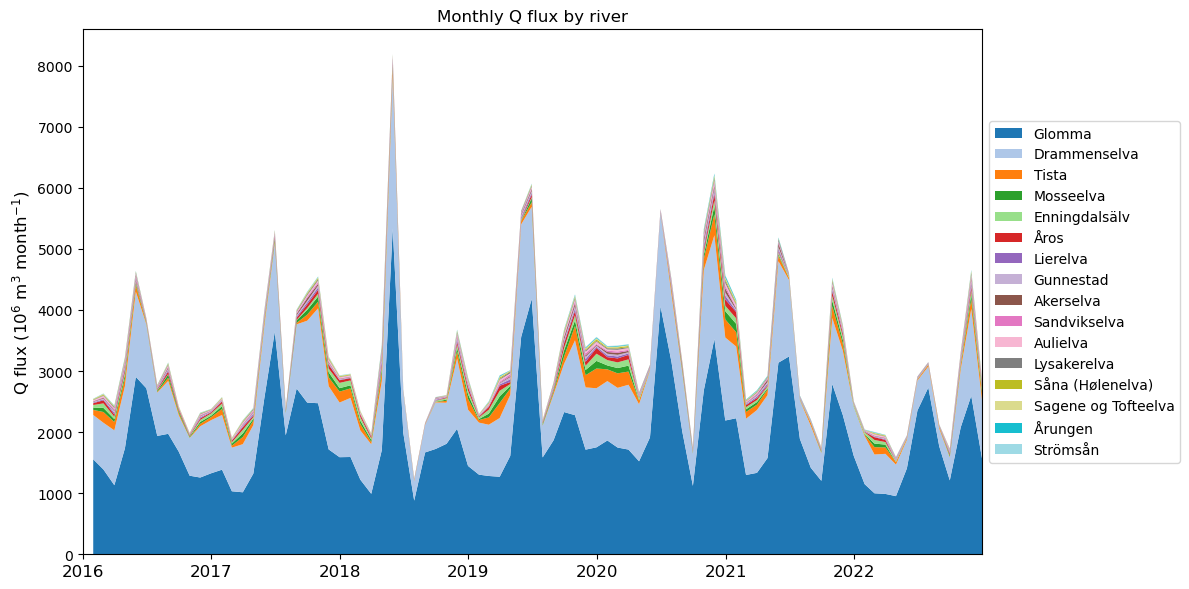

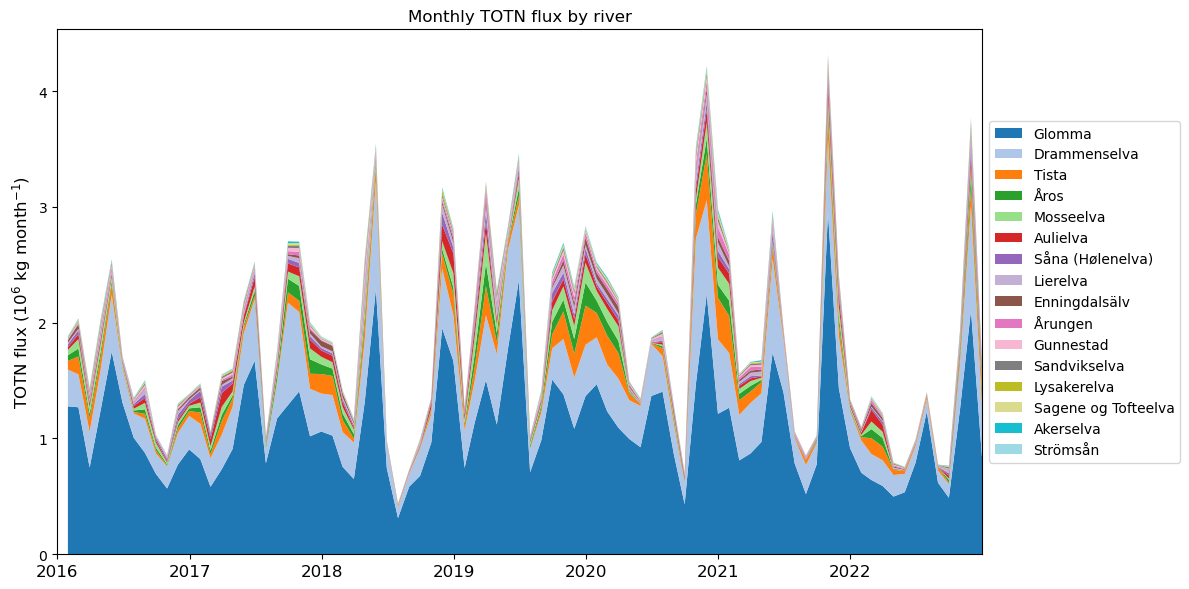

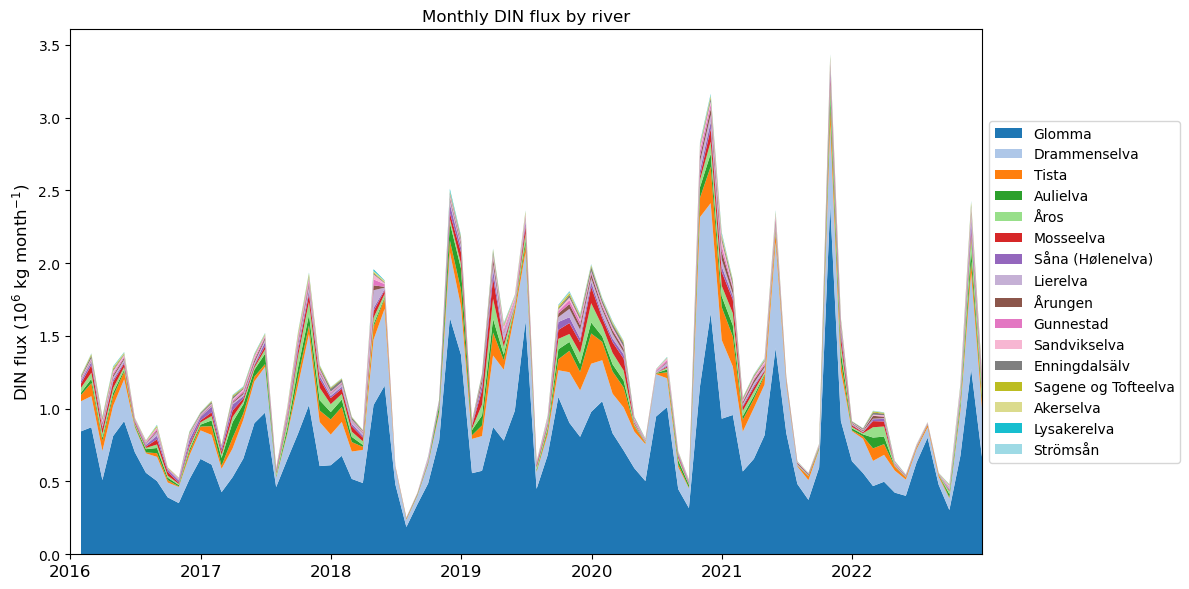

In [61]:
# Plot stacked line chart

monthflux_unit_dict = {
    "Q": "10$^6$ m$^3$ month$^{-1}$",
    "TOTN": "10$^6$ kg month$^{-1}$",
    "DIN": "10$^6$ kg month$^{-1}$",
}

for var in ["Q", "TOTN", "DIN"]:

    pivot_df = monthly_load_df.pivot(index="date", columns="river", values=var)

    total_contribution = (
        monthly_load_df.groupby("river")[var].sum().sort_values(ascending=False)
    )

    # Order the columns of pivot_df according to total_contribution
    ordered_pivot_df = pivot_df[total_contribution.index]

    # Generate colors
    cmap = matplotlib.colormaps.get_cmap("tab20")  # 'tab20' is a colormap with 20 distinct colors
    colors = cmap(np.linspace(0, 1, len(ordered_pivot_df.columns)))

    # Plot
    plt.figure(figsize=(12, 6))
    plt.stackplot(
        ordered_pivot_df.index,
        ordered_pivot_df.T,
        labels=ordered_pivot_df.columns,
        colors=colors,
    )
    xmin = matplotlib.dates.datestr2num('2016-01-01')
    xmax = matplotlib.dates.datestr2num('2022-12-31')
    plt.xlim([xmin, xmax])
    plt.title("Monthly %s flux by river" % var)
    plt.ylabel(f"{var} flux ({monthflux_unit_dict[var]})", fontsize=12)
    plt.xticks(fontsize=12)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

    fpath = os.path.join(fig_folder, f'monthly_flux_{var}_{start_year}-{end_year}.png')
    plt.savefig(fpath)

    plt.show()

## Mean monthly mean fluxes

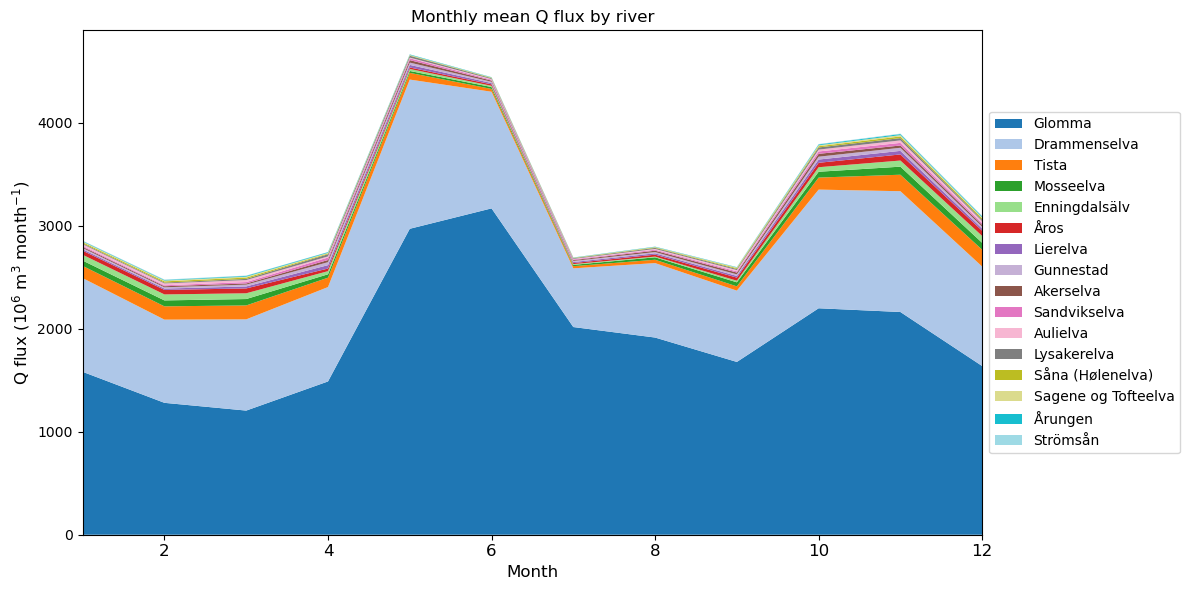

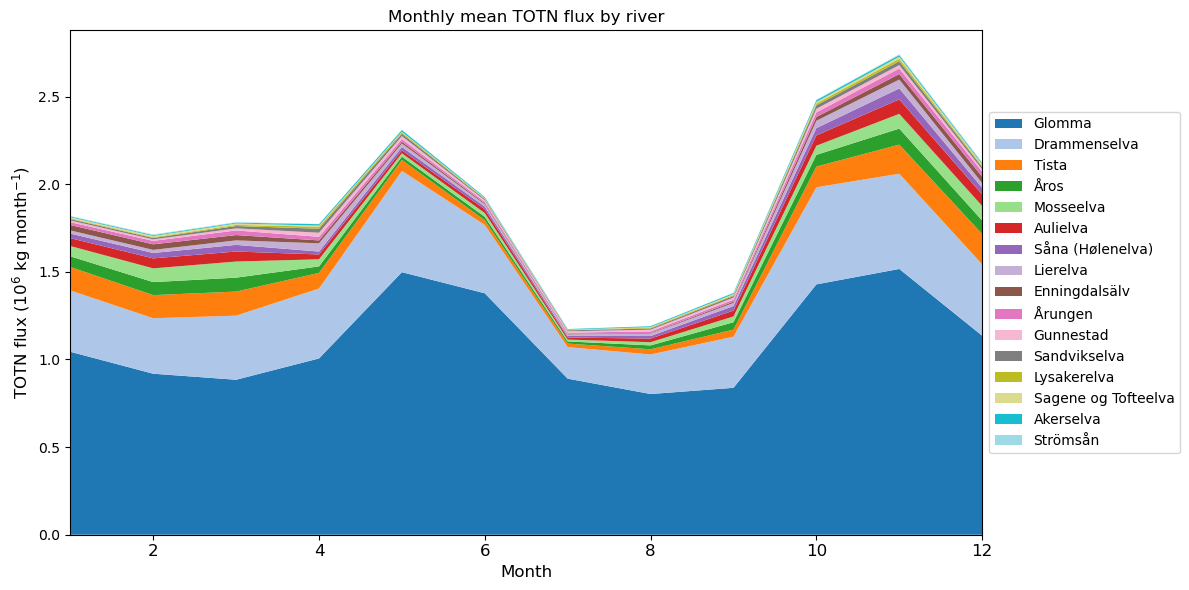

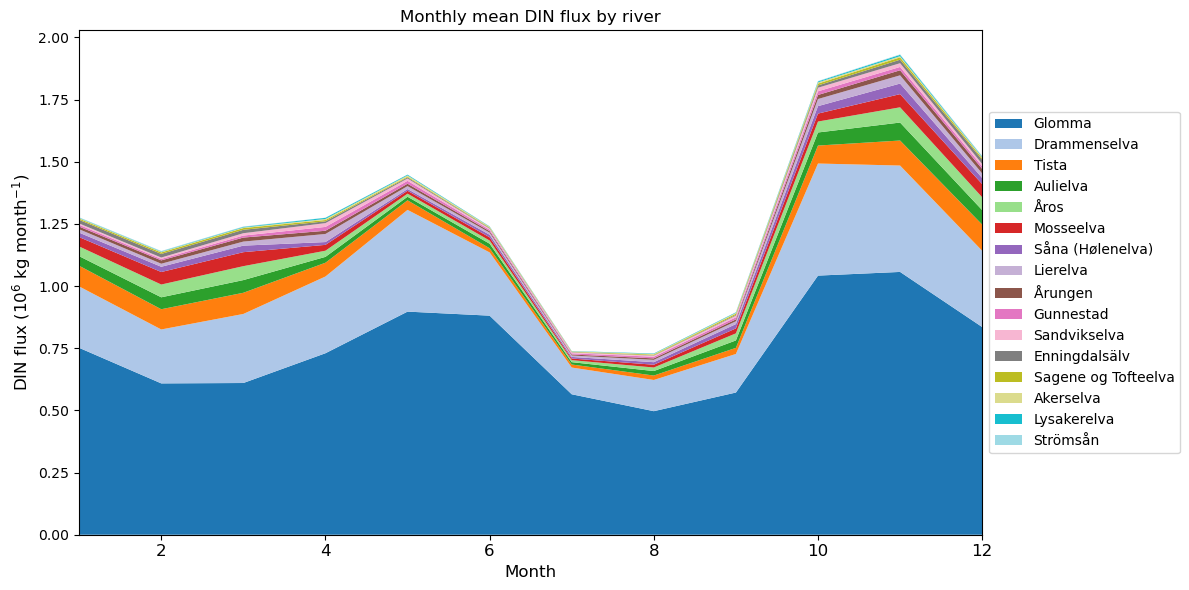

In [62]:
# Plot
for var in ["Q", "TOTN", "DIN"]:

    pivot_df = monthly_mean_load_df.pivot(index="month", columns="river", values=var)

    total_contribution = (
        monthly_mean_load_df.groupby("river")[var].sum().sort_values(ascending=False)
    )

    # Order the columns of pivot_df according to total_contribution
    ordered_pivot_df = pivot_df[total_contribution.index]

    # Generate colors
    cmap = matplotlib.colormaps.get_cmap("tab20")  # colormap with 20 colors
    colors = cmap(np.linspace(0, 1, len(ordered_pivot_df.columns)))

    # Plot
    plt.figure(figsize=(12, 6))
    plt.stackplot(
        ordered_pivot_df.index,
        ordered_pivot_df.T,
        labels=ordered_pivot_df.columns,
        colors=colors,
    )
    plt.xlim([1, 12])
    plt.title("Monthly mean %s flux by river" % var)
    plt.ylabel(f"{var} flux ({monthflux_unit_dict[var]})", fontsize=12)
    plt.xlabel("Month", fontsize=12)
    plt.xticks(fontsize=12)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    fpath = os.path.join(fig_folder, f'monthly_mean_flux_{var}_{start_year}-{end_year}.png')
    plt.savefig(fpath)

    plt.show()

## Annual fluxes

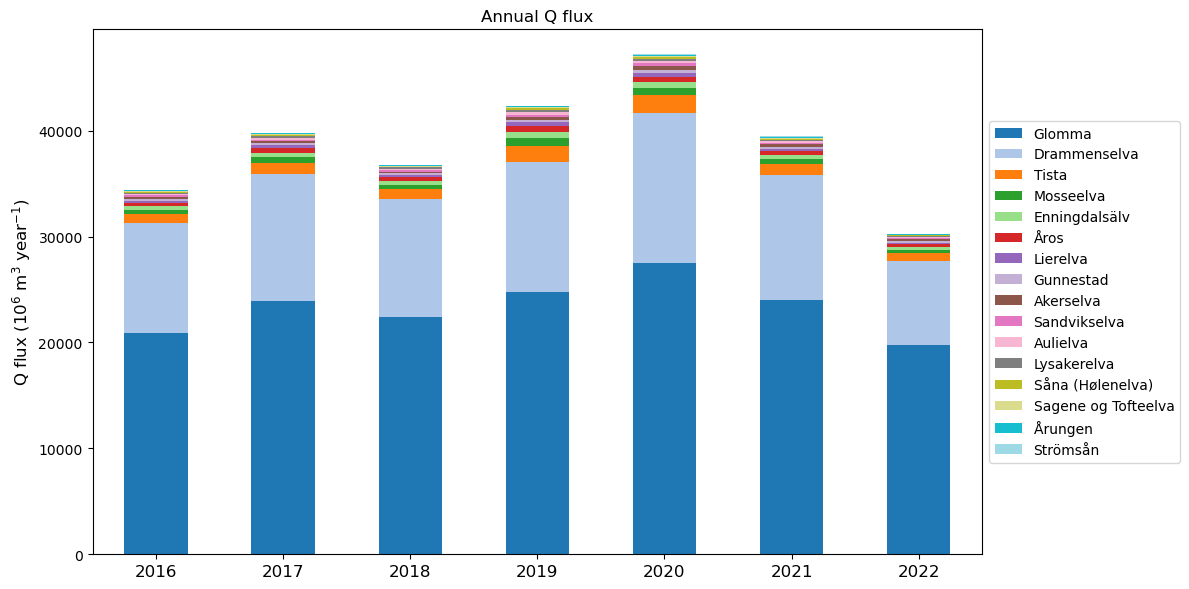

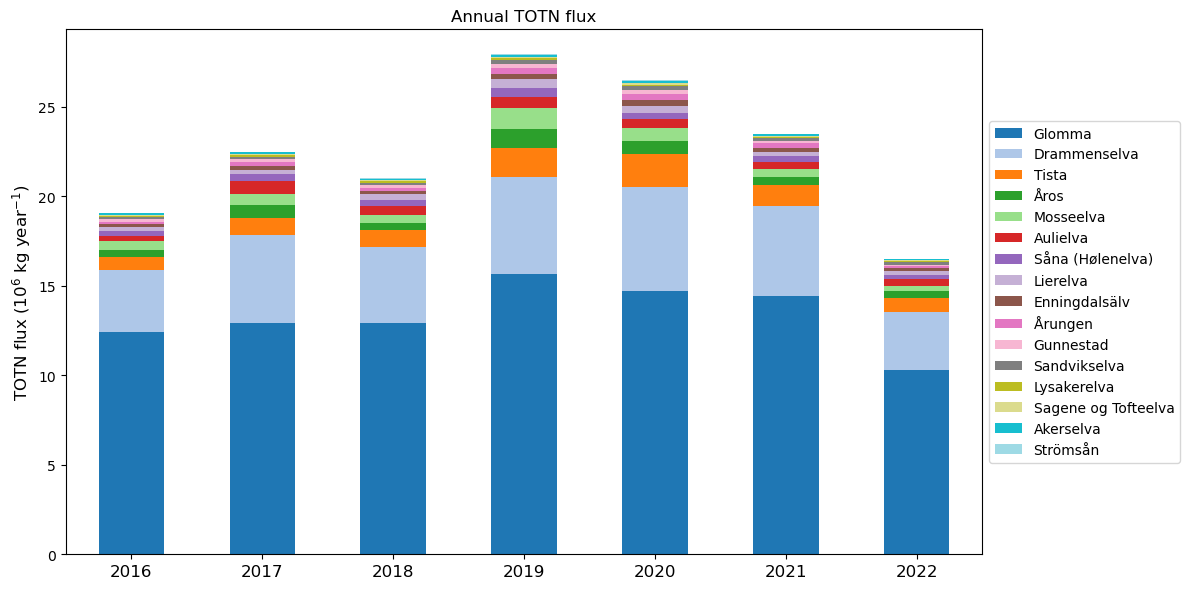

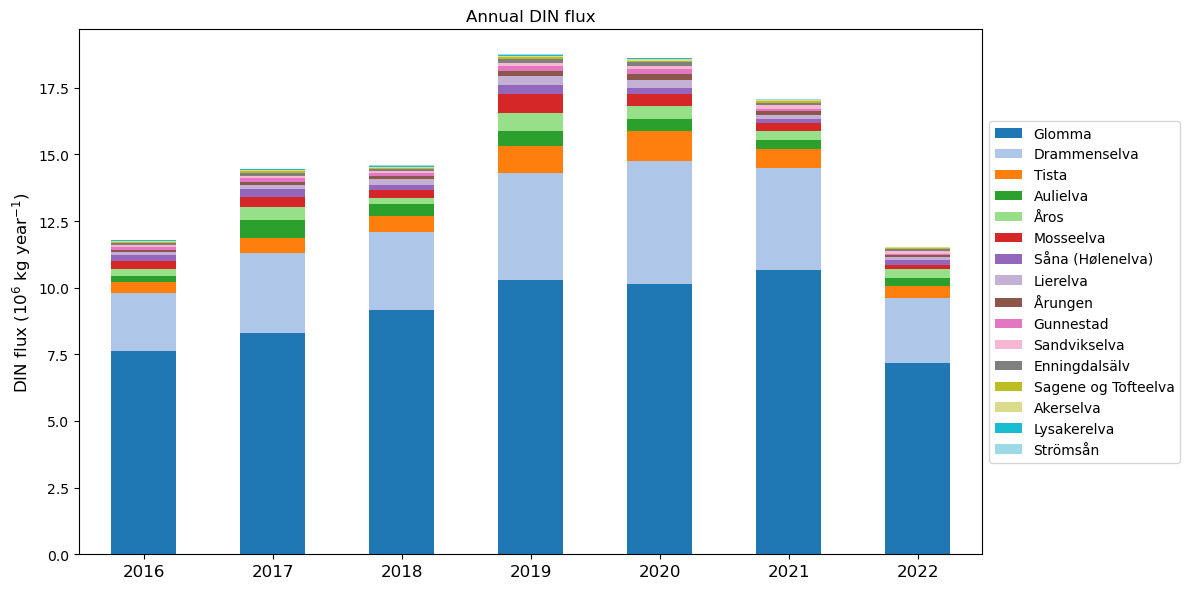

In [63]:
annualflux_unit_dict = {
    "Q": "10$^6$ m$^3$ year$^{-1}$",
    "TOTN": "10$^6$ kg year$^{-1}$",
    "DIN": "10$^6$ kg year$^{-1}$",
}

for var in ["Q", "TOTN", "DIN"]:

    pivot_df = annual_load_df.pivot(index="year", columns="river", values=var)
    total_contribution = (
        annual_load_df.groupby("river")[var].sum().sort_values(ascending=False)
    )
    ordered_pivot_df = pivot_df[total_contribution.index]

    # Generate colors
    cmap = matplotlib.colormaps.get_cmap("tab20")  # colormap with 20 colors
    colors = cmap(np.linspace(0, 1, len(ordered_pivot_df.columns)))

    # Plot
    plt.figure(figsize=(12, 6))

    # Use DataFrame.plot to create a stacked bar plot
    ordered_pivot_df.plot(kind='bar', stacked=True, color=colors, ax=plt.gca())

    plt.title("Annual %s flux" % var)
    plt.ylabel(f"{var} flux ({annualflux_unit_dict[var]})", fontsize=12)
    plt.xlabel('')
    # plt.xlabel("Year", fontsize=12)
    plt.xticks(rotation=0, fontsize=12)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    
    fpath = os.path.join(fig_folder, f'annual_flux_{var}_{start_year}-{end_year}.png')
    plt.savefig(fpath)

    plt.show()

# Plot boxplots

## Boxplots of daily values

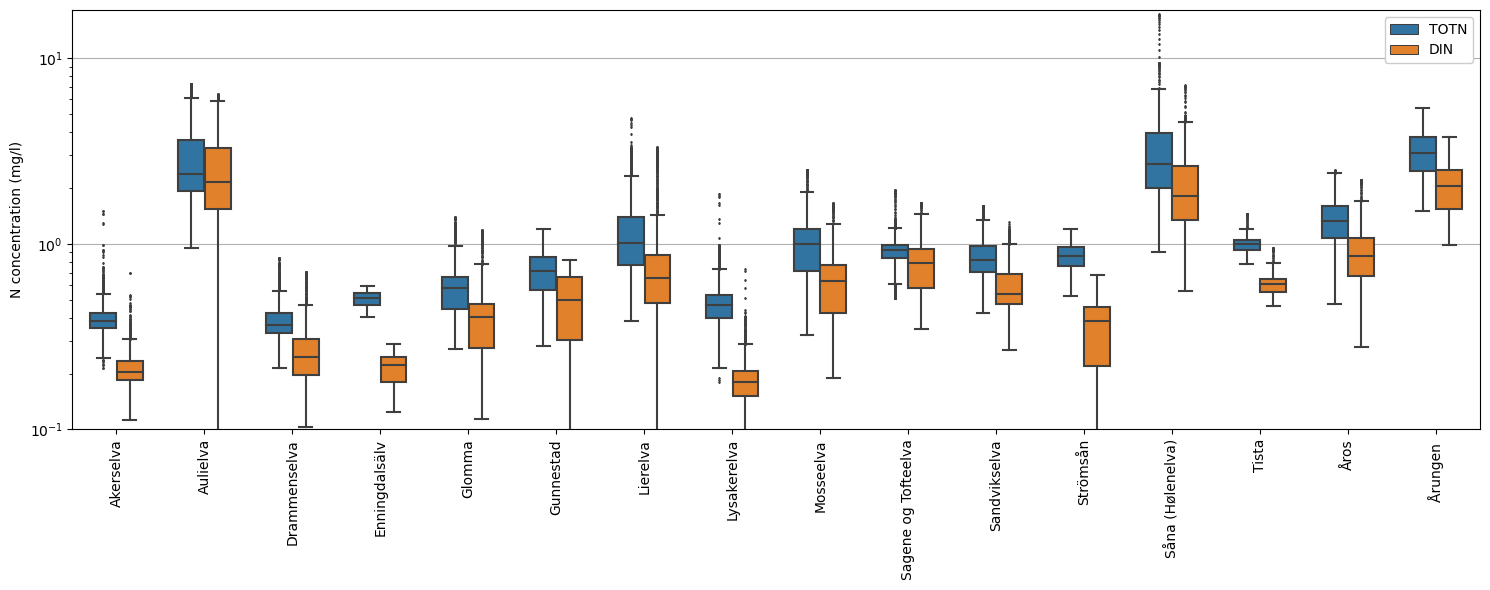

In [67]:
# Melt your DataFrame to have rivers, dates, variable (column1 or column2), and value
df_melted = conc_df[['TOTN', 'DIN', 'river', 'date']].melt(id_vars=['river', 'date'], var_name='variable', value_name='value')

# Create a boxplot
plt.figure(figsize=(15, 6))
box_plot = sns.boxplot(x='river', y='value', hue='variable', data=df_melted, fliersize=1, width=0.6, showfliers=True)

# Tidy up
box_plot.set_xlabel('')
box_plot.legend(title=None, framealpha=1)
plt.xticks(rotation=90)
plt.ylim(0.1,)
plt.yscale('log')
plt.grid(axis='y')
ax = plt.gca()  # Get the current Axes instance
ax.set_axisbelow(True)  # Set gridlines to be below other graph elements

plt.ylabel('N concentration (mg/l)')
# plt.title('Boxplot of Concentrations by River')

plt.tight_layout()
fpath = os.path.join(fig_folder, f'daily_conc_boxplots_{start_year}-{end_year}.png')
plt.savefig(fpath)

plt.show()